# Задача 3. Сравнение методов классификации

## Собственные реализации

### Метод k-ближайших соседей

Гиперпараметры:
- `n_neighbors` -- количество учитываемых соседей
- `weights` -- способ назначения весов соседям
  - `'uniform'` -- все учитываемые соседи имеют одинаковый вес
  - `'distance'` -- вес обратно пропорционален расстоянию до соседа

Данная реализация всегда использует Евклидово расстояние.

In [1]:
import heapq
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
class MyKNNClassifier(BaseEstimator):
    def __init__(self, n_neighbors=5, weights='uniform'):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predicted_labels = [self._predict(x) for x in X]
        return np.array(predicted_labels)

    def _predict(self, x):
        # negative distance acts a key in this max-heap
        closest_data_points_heap = []
        for i, x_train in enumerate(self.X_train):
            distance = -np.sum((x_train - x) ** 2)
            if len(closest_data_points_heap) < self.n_neighbors:
                heapq.heappush(closest_data_points_heap, (distance, i))
            else:
                heapq.heappushpop(closest_data_points_heap, (distance, i))
        class_weight = {}
        for d, i in closest_data_points_heap:
            label = self.y_train[i]

            if self.weights == 'distance':
              weight = 1 / np.sqrt(-d) if d != 0 else 1e100
            elif self.weights == 'uniform':
              weight = 1
            else:
              raise ValueError("Invalid value for weights parameter")

            if label in class_weight:
                class_weight[label] += weight
            else:
                class_weight[label] = weight

        return max(class_weight, key=class_weight.get)

### Логистическая линейная регрессия методом градиентного спуска

Собственная реализация обучения модели линейной регрессии. Минимизируется функционал ошибки $LogLoss + L_2$-регуляризация.

Данная оптимизирует функционал:
* методом градиентного спуска (Batch Gradient Descent, GD), когда `batch_size=None`
* методом стохастического градиентного спуска (Stochastic Gradient Descent, SGD), когда `batch_size=1`
* методом мини-пакетного градиентного спуска (Mini Batch Gradient Descent), иначе

In [ ]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, learning_rate=0.01, epochs=1000, batch_size=None, C=1.0):
        self.weights = None
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.C = C

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        X = np.c_[np.ones(n_samples), X]

        self.weights = np.random.randn(n_features + 1)

        for _ in range(self.epochs):
            if self.batch_size is None:
                X_batch = X
                y_batch = y
            else:
                indices = np.random.choice(n_samples, self.batch_size)
                X_batch = X[indices]
                y_batch = y[indices]

            predictions = self.sigmoid(X_batch @ self.weights)
            gradients = X_batch.T @ (predictions - y_batch) / n_samples

            regularization_term = self.weights / n_samples / self.C
            regularization_term[0] = 0  # Do not regularize the bias term
            gradients += regularization_term

            self.weights -= self.learning_rate * gradients

    def predict_proba(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        return self.sigmoid(X @ self.weights)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

## Набор данных "Заболевания сердца"

Загрузим [набор данных "Заболевания сердца"](https://github.com/rustam-azimov/ml-course/blob/68d2bb1aebeeb20f8cf1dd4bdddcfe8dc24d9f1e/data/heart_disease/heart.csv).

In [ ]:
df = pd.read_csv('heart.csv')

Описание набора данных:

  - `age` - age in years
  - `sex` - (1 = male; 0 = female)
  - `cp` - chest pain type
  - `trestbps` - resting blood pressure (in mm Hg on admission to the hospital)
  - `chol` - serum cholestoral in mg/dl
  - `fbs` - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
  - `restecg` - resting electrocardiographic results
  - `thalach` - maximum heart rate achieved
  - `exang` - exercise induced angina (1 = yes; 0 = no)
  - `oldpeak` - ST depression induced by exercise relative to rest
  - `slope` - the slope of the peak exercise ST segment
  - `ca` - number of major vessels (0-3) colored by flourosopy
  - `thal` - 3 = normal; 6 = fixed defect; 7 = reversable defect
  - `target` - have disease or not (1=yes, 0=no)

Необходимо решить задачу классификации и научиться предсказывать целевой признак `target`, имеет ли пациент заболевание сердца.

### Разведочный анализ и преобразования

Рассмотрим несколько записей.

In [ ]:
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


Заметим, что предсказываемые классы почти идеально сбалансированы, поэтому не будем использовать методики, улучшающие качество моделей при работе с несбалансированными классами.

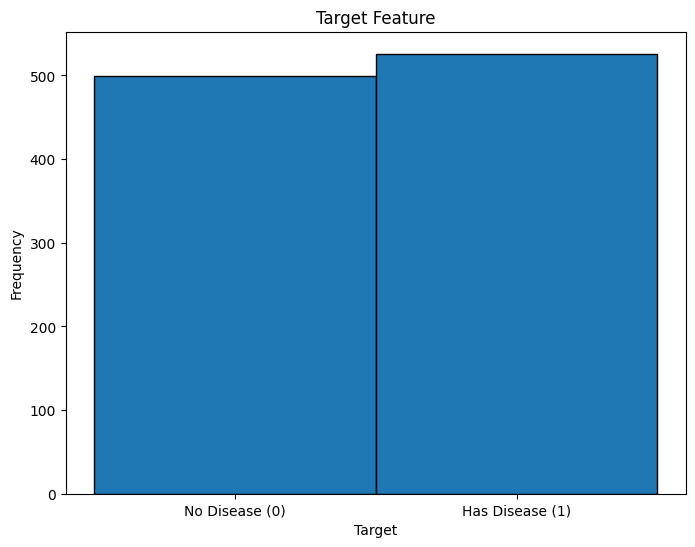

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['target'], bins=2, edgecolor='black')
plt.title('Target Feature')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.xticks([0.25, 0.75], ['No Disease (0)', 'Has Disease (1)'])
plt.show()

Построим гистограммы нецелевых признаков.

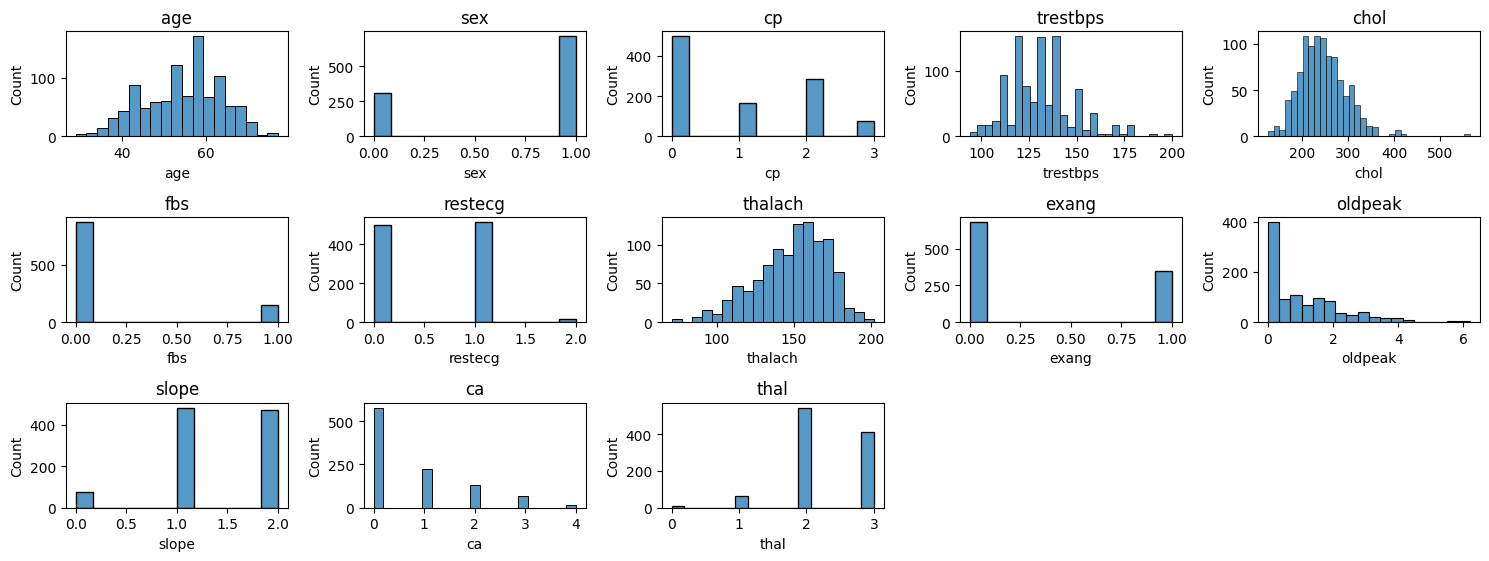

In [ ]:
features = df.columns.drop('target')

plt.figure(figsize=(15, 9))
for i, feature in enumerate(features):
    plt.subplot(5, 5, i + 1)
    sns.histplot(df[feature], kde=False, edgecolor='black')
    plt.title(feature)
    plt.tight_layout()

plt.show()

Заметим, что в наборе данных есть категориальные признаки, закодируем их с помощью One-Hot Encoding. При этом не считаем признак `ca` категориальным, несмотря на малое количество различных значений, чтобы не потерять его количественную природу (см. описание и распределение признака `ca`).

In [ ]:
categorical_features = ['cp', 'restecg', 'thal', 'slope']

df = pd.concat(
  [df.drop(columns=categorical_features), pd.get_dummies(df[categorical_features].astype(str), drop_first=True)],
  axis=1
)

In [ ]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Также заметим, что количественные признаки имеют разные диапазоны значений. Стандартизируем их, так как это предпочтительно при использовании регуляризации и метода k-ближайших соседей.

In [ ]:
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

Убедимся, что признаки были правильно преобразованы.

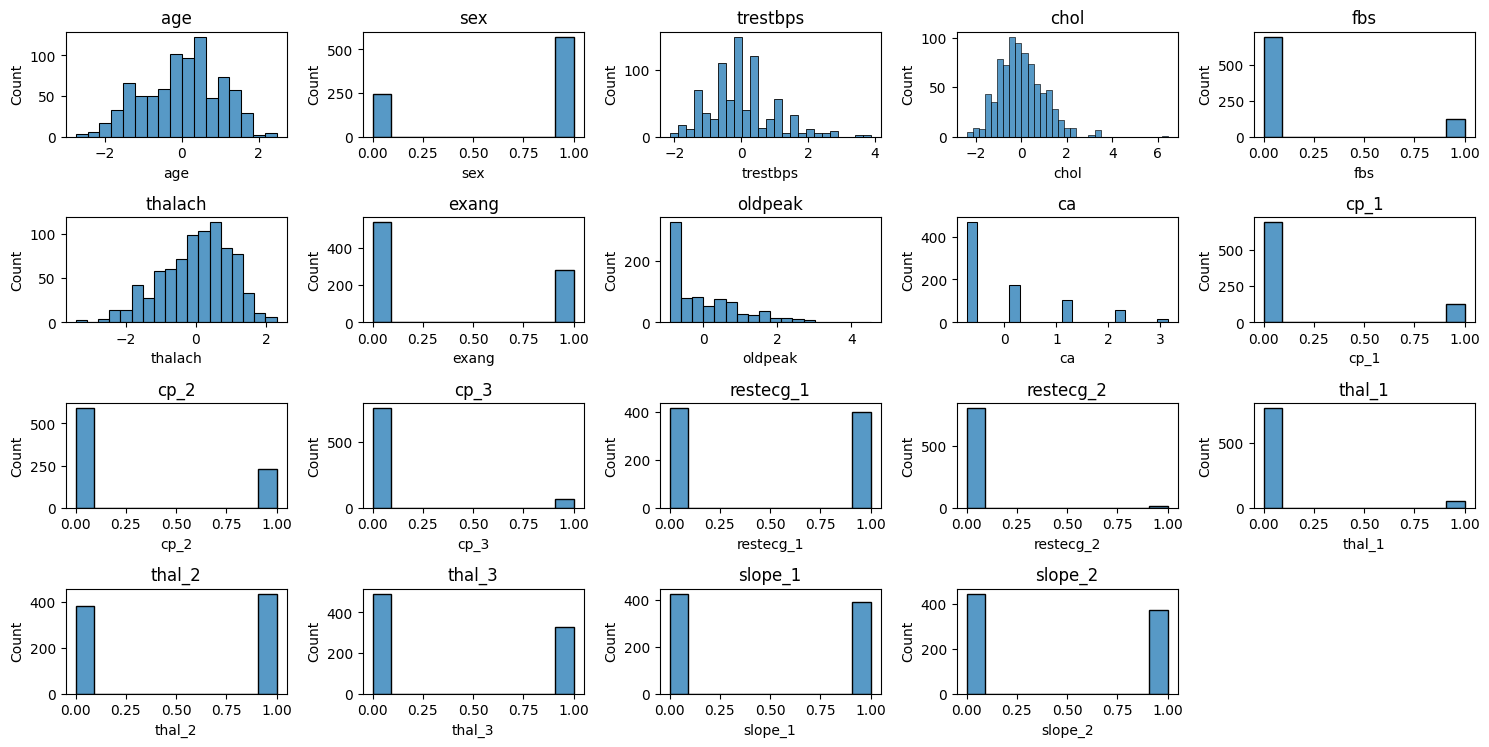

In [ ]:
features = df.columns.drop('target')

plt.figure(figsize=(15, 9))
for i, feature in enumerate(features):
    plt.subplot(5, 5, i + 1)
    sns.histplot(X_train[feature], kde=False, edgecolor='black')
    plt.title(feature)
    plt.tight_layout()

plt.show()

Построим матрицу корреляции, примем решение оставить все имеющие признаки, так как сильно коррелирующих признаков достаточно мало.

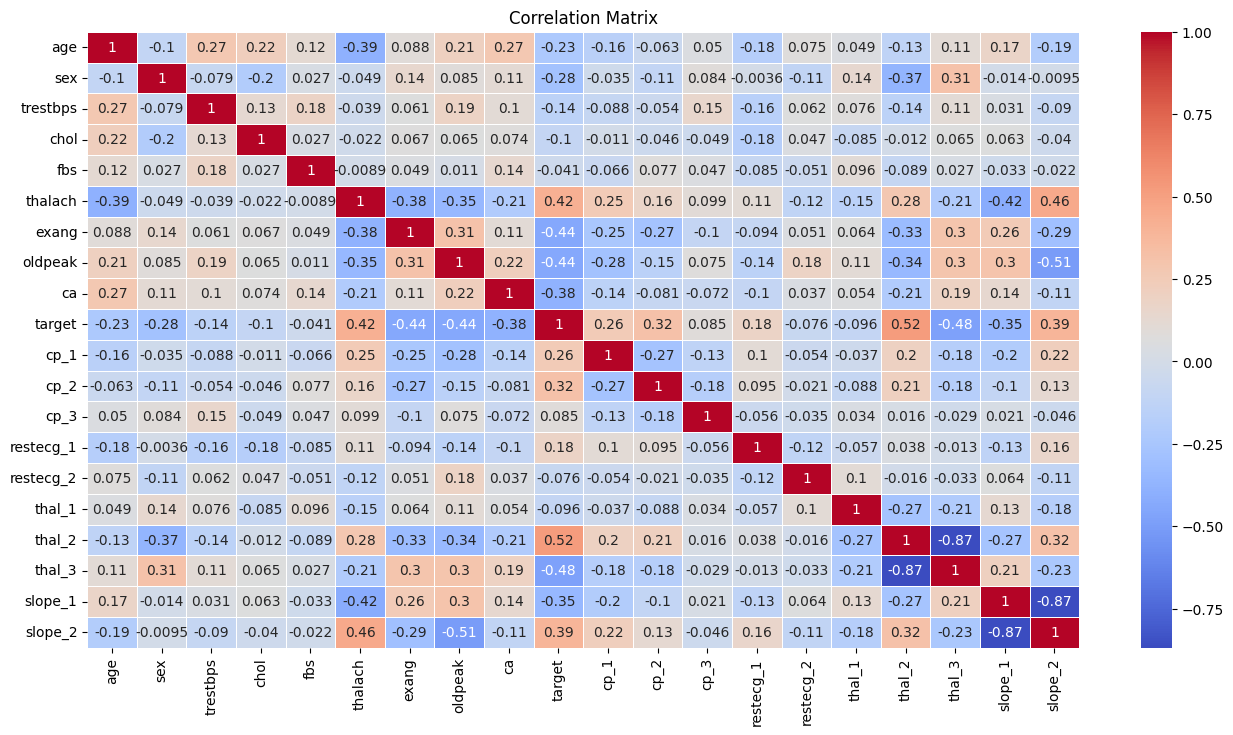

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

### Сравнение методов классификации

Сравним на наборе данных "Заболевания сердца" собственные реализации `MyLogisticRegression` и `MyKNNClassifier` и библиотечные реализации `LogisticRegression`, `SVC`, `KNeighborsClassifier`, `GaussianNB` и `DecisionTreeClassifier` из библиотеки `sklearn`. Будем использовать подбор гиперпараметров с кросс-валидацией.

In [ ]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
def train_evaluate_model(model, params):
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    print(f"Model: {best_model.__class__.__name__}")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print()

    return confusion_matrix(y_test, y_pred_test)

In [ ]:
models = {
    'MyLogisticRegression': (MyLogisticRegression(), {'C': [0.01, 0.1, 1, 10, 100], 'learning_rate': [0.001, 0.01, 0.1, 0.5, 1.0], 'epochs': [1000, 2000, 4000]}),
    'LogisticRegression': (LogisticRegression(), {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['newton-cg', 'liblinear']}),
    'SVM': (SVC(), {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto', 0.1, 1, 10]}),
    'MyKNN': (MyKNNClassifier(), {'n_neighbors': [1, 3, 5, 7, 11, 15], 'weights': ['uniform', 'distance']}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 11, 15], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}),
    'NaiveBayes': (GaussianNB(), {}),
    'DecisionTree': (DecisionTreeClassifier(), {'max_depth': [None, 3, 5, 7, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]})
}

In [ ]:
def train_models():
  fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
  for ax, (name, (model, params)) in zip(axes.flatten(), models.items()):
    cm = train_evaluate_model(model, params)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.title.set_text(f'{model.__class__.__name__}')
  fig.delaxes(axes[1, 3]) # hide last empty plot
  plt.tight_layout()
  plt.show()

Model: MyLogisticRegression
Best Params: {'C': 10, 'epochs': 1000, 'learning_rate': 1.0}
Train Accuracy: 0.8829
Test Accuracy: 0.8195

Model: LogisticRegression
Best Params: {'C': 10, 'solver': 'newton-cg'}
Train Accuracy: 0.8829
Test Accuracy: 0.8195

Model: SVC
Best Params: {'C': 0.01, 'gamma': 10, 'kernel': 'poly'}
Train Accuracy: 1.0000
Test Accuracy: 0.9854

Model: MyKNNClassifier
Best Params: {'n_neighbors': 15, 'weights': 'distance'}
Train Accuracy: 1.0000
Test Accuracy: 1.0000

Model: KNeighborsClassifier
Best Params: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
Train Accuracy: 1.0000
Test Accuracy: 1.0000

Model: GaussianNB
Best Params: {}
Train Accuracy: 0.8537
Test Accuracy: 0.8000

Model: DecisionTreeClassifier
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Train Accuracy: 1.0000
Test Accuracy: 1.0000



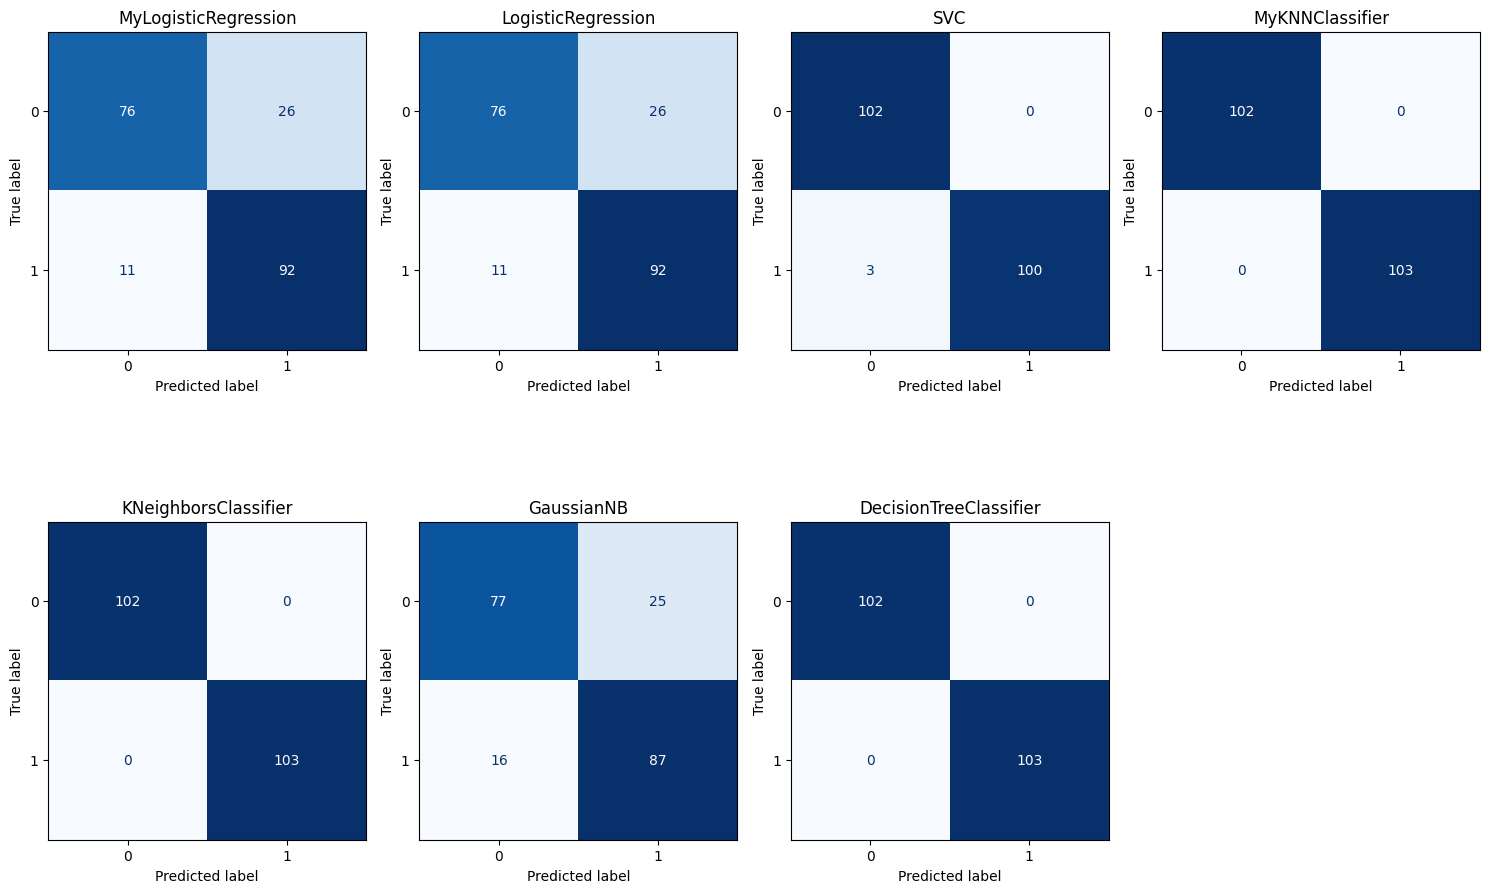

In [ ]:
train_models()

Наилучшие результаты показали классификаторы `MyKNNClassifier`, `KNeighborsClassifier`, `DecisionTreeClassifier` и `SVC`. Что примечательно, собственные реализации показали результаты идентичные соответствующим библиотечным реализациям.

## Набор данных "Мины и камни"

Загрузим [набор данных "Мини и камни"](https://www.kaggle.com/datasets/mattcarter865/mines-vs-rocks).

In [2]:
df = pd.read_csv('sonar.all-data.csv')

Описание набора данных:

  - `R` - категория ('R' (rock) у камней и 'M' (mine) у мин)
  - Остальные признаки описывают измерения сонаром на разных частотах

Необходимо решить задачу классификации и научиться предсказывать целевой признак `R`, является ли объект миной или камнем.

### Разведочный анализ и преобразования

Рассмотрим несколько записей.

In [3]:
df.head()

,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
0,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
1,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
2,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
3,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
4,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R


Заметим, что предсказываемые классы достаточно сбалансированы, поэтому не будем использовать методики, улучшающие качество моделей при работе с несбалансированными классами.

In [ ]:
y = np.array(df['R'] == 'M')
X = df.drop(columns=['R'])

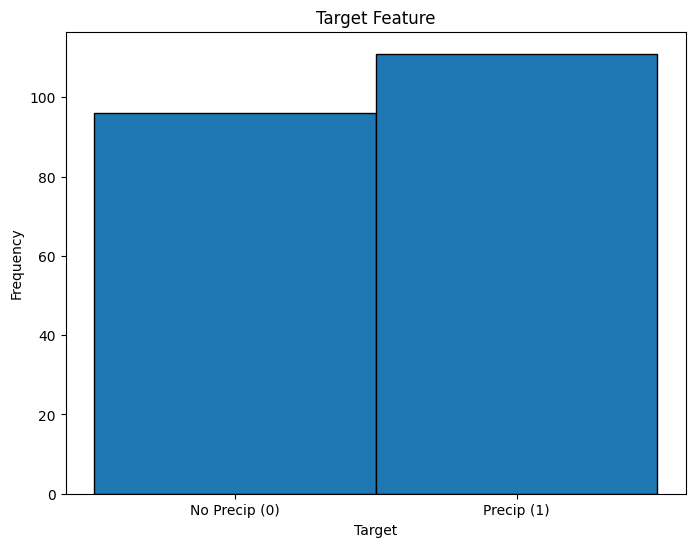

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(y.astype(int), bins=2, edgecolor='black')
plt.title('Target Feature')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.xticks([0.25, 0.75], ['No Precip (0)', 'Precip (1)'])
plt.show()

Построим гистограммы нецелевых признаков.

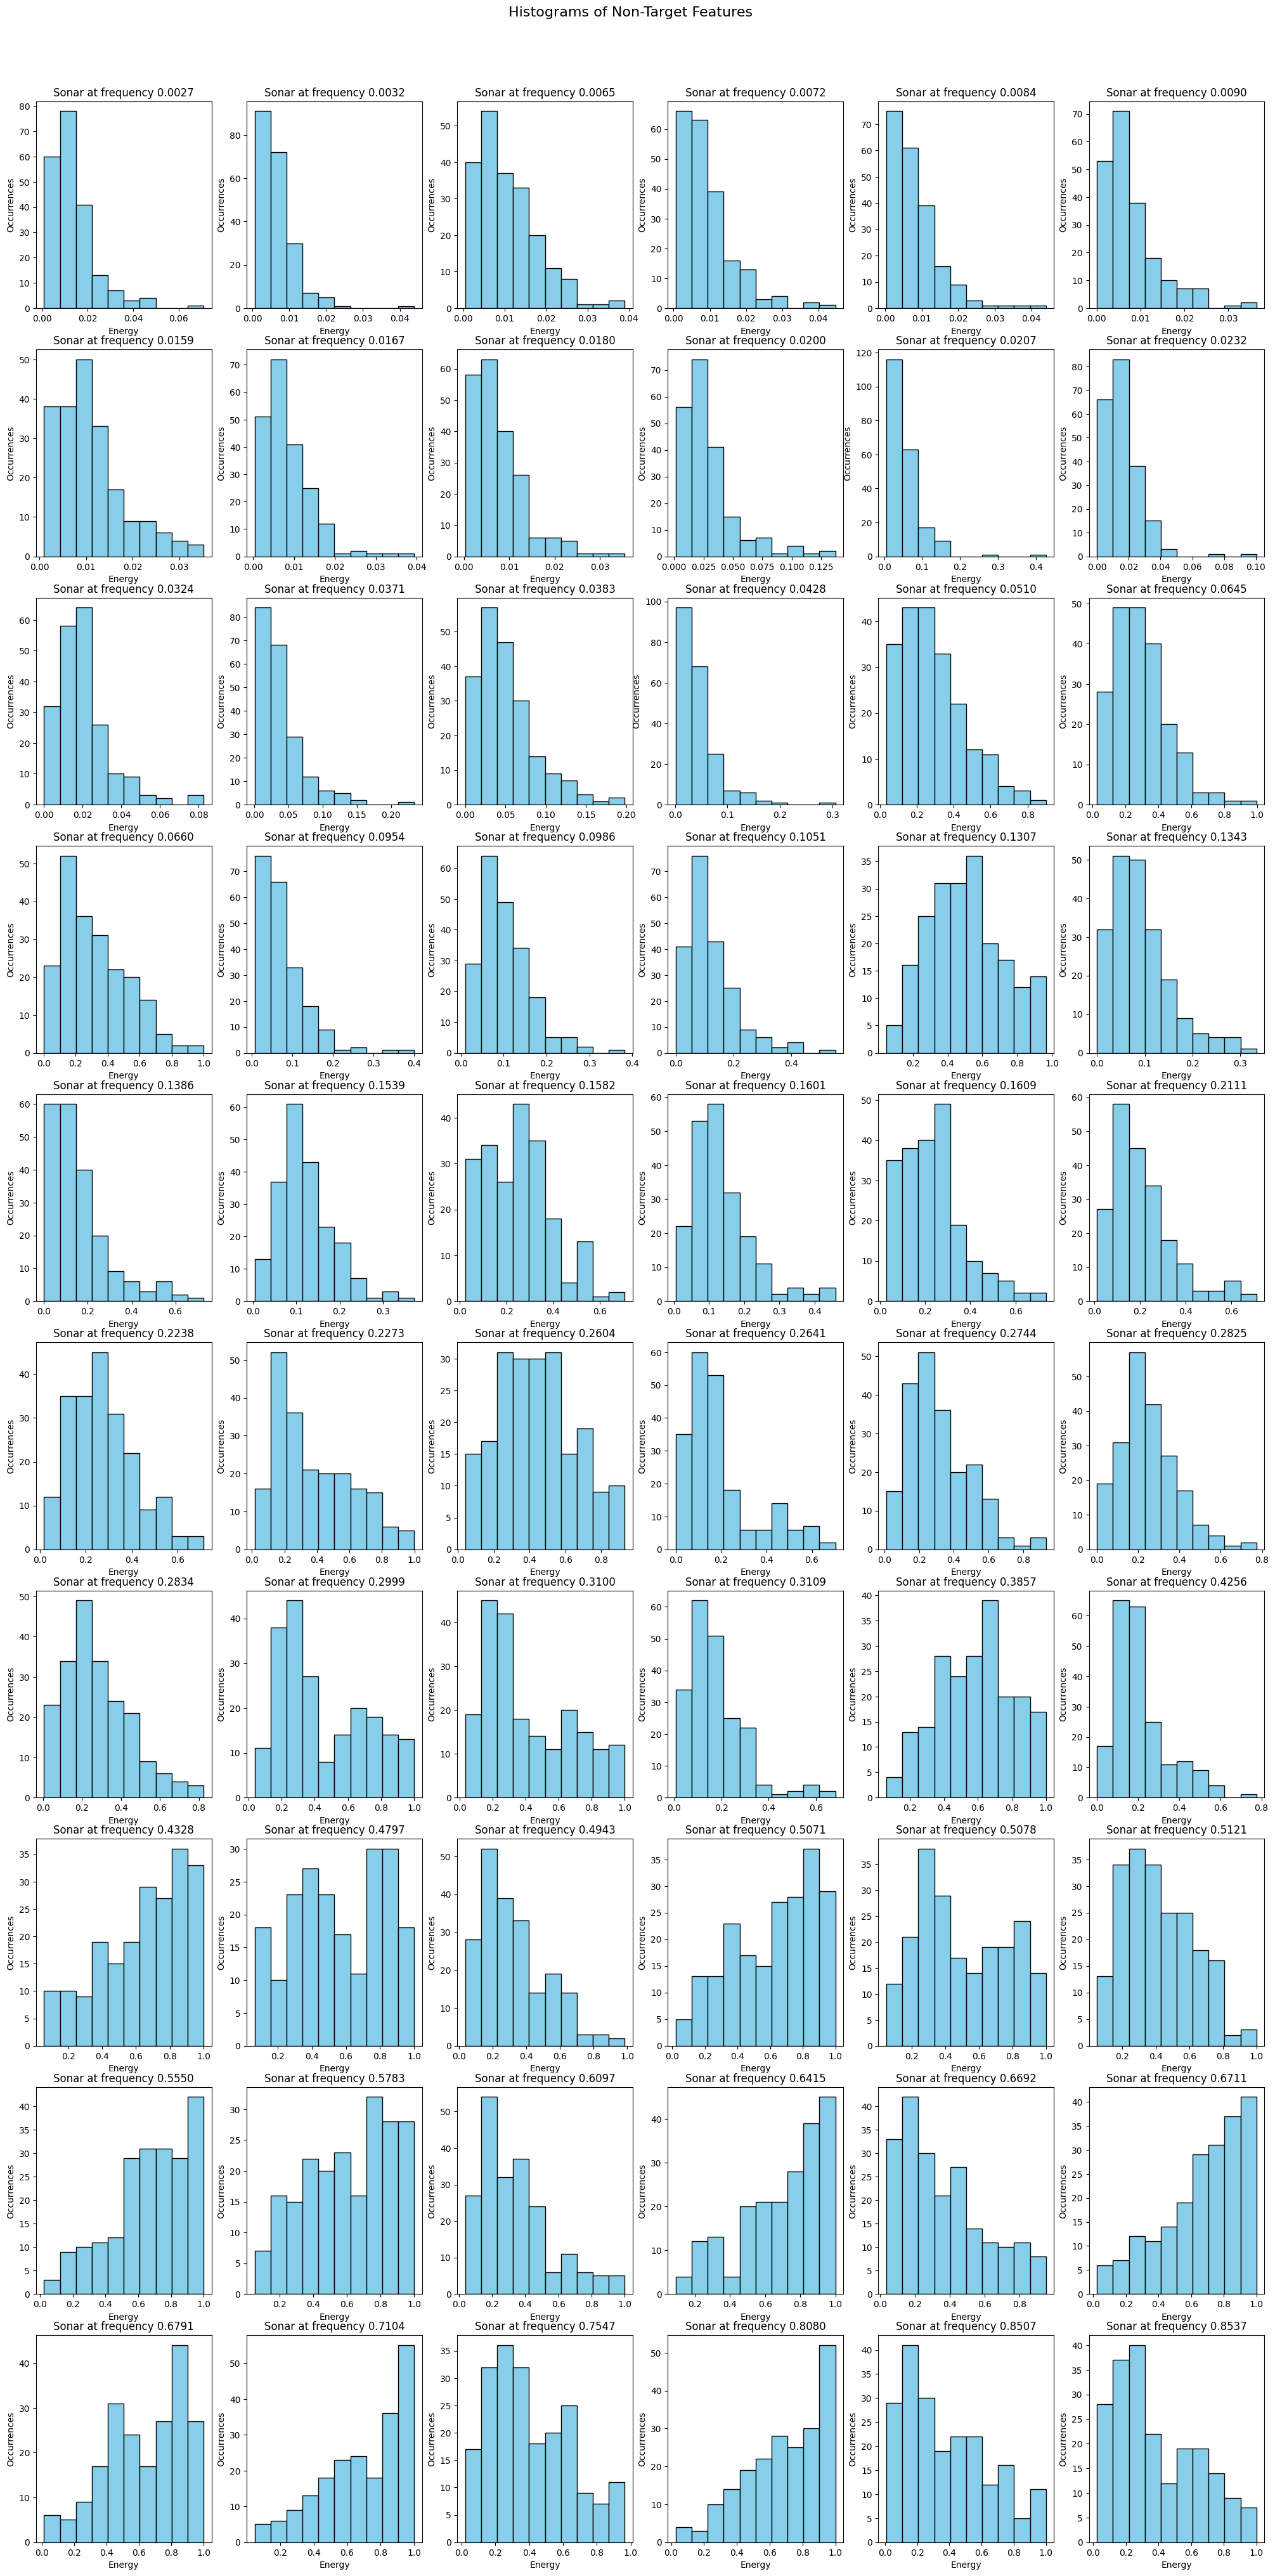

In [ ]:
def plot_histogram_for_every_feature(df, title):
    num_columns = len(df.columns)
    plots_per_row = 6
    num_rows = (num_columns + plots_per_row - 1) // plots_per_row

    fig, axes = plt.subplots(
        nrows=num_rows,
        ncols=plots_per_row,
        figsize=(25, num_rows * 5)
    )

    axes = axes.flatten()

    for i, column in enumerate(sorted(df.columns, key=float)):
        axes[i].hist(df[str(column)], color='skyblue', edgecolor='black')
        axes[i].set_title(f'Sonar at frequency {column}')
        axes[i].set_ylabel('Occurrences')
        axes[i].set_xlabel('Energy')

    for j in range(num_columns, num_rows * plots_per_row):
        fig.delaxes(axes[j])

    fig.suptitle(f"Histograms of {title}", fontsize=16, y=0.91)

plot_histogram_for_every_feature(X, "Non-Target Features")

Заметим, что в наборе присутствуют только количественные признаки, эти признаки имеют разные диапазоны значений и при этом их распределение не является нормальным. По этим причинам масштабируем признаки с помощью `MinMaxScaler`.

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Построим матрицу корреляции, примем решение оставить все имеющие признаки, так как сильно коррелирующих признаков не слишком много.

<ipython-input-25-79f745684579>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


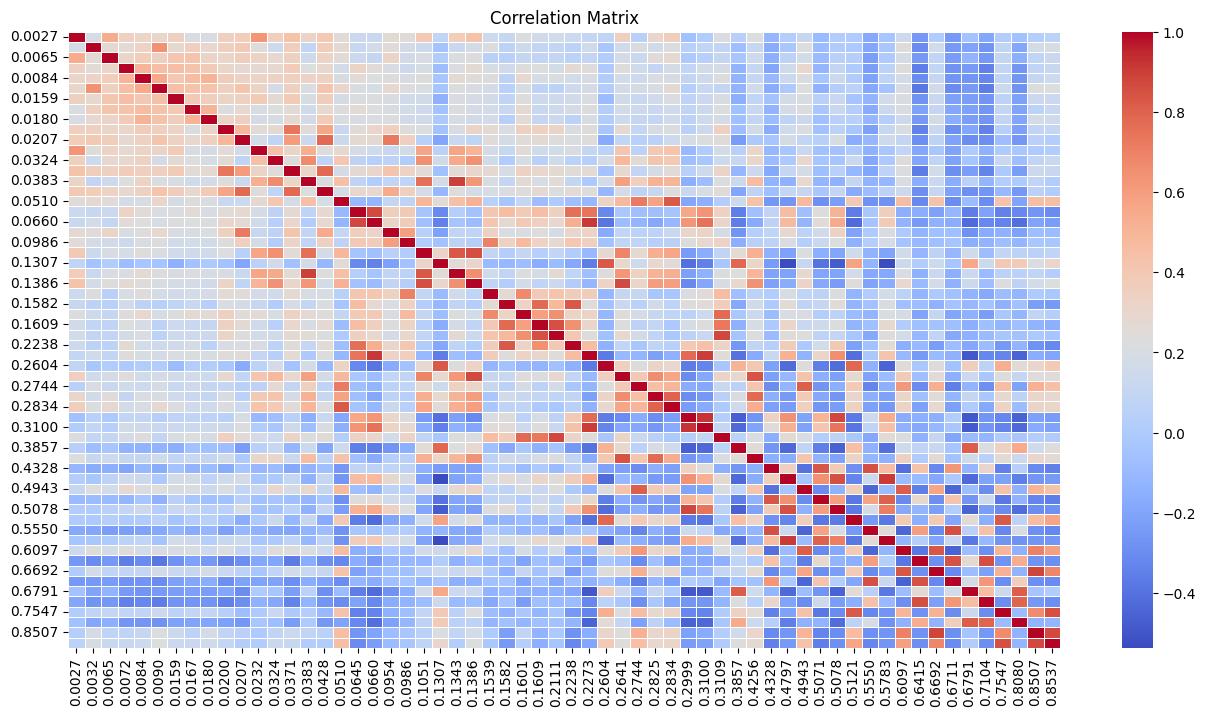

In [ ]:
correlation_matrix = df.corr()
sorted_columns = sorted(correlation_matrix.columns, key=float)
correlation_matrix = correlation_matrix.reindex(index=sorted_columns, columns=sorted_columns)
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

### Сравнение методов классификации

Сравним на наборе данных "Мины и камни" собственные реализации `MyLogisticRegression` и `MyKNNClassifier` и библиотечные реализации `LogisticRegression`, `SVC`, `KNeighborsClassifier`, `GaussianNB` и `DecisionTreeClassifier` из библиотеки `sklearn`. Будем использовать подбор гиперпараметров с кросс-валидацией.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Model: MyLogisticRegression
Best Params: {'C': 100, 'epochs': 4000, 'learning_rate': 0.5}
Train Accuracy: 0.9212
Test Accuracy: 0.7619

Model: LogisticRegression
Best Params: {'C': 10, 'solver': 'liblinear'}
Train Accuracy: 0.9091
Test Accuracy: 0.7619

Model: SVC
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Train Accuracy: 1.0000
Test Accuracy: 0.8333

Model: MyKNNClassifier
Best Params: {'n_neighbors': 1, 'weights': 'uniform'}
Train Accuracy: 1.0000
Test Accuracy: 0.7619

Model: KNeighborsClassifier
Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Train Accuracy: 0.9273
Test Accuracy: 0.7857

Model: GaussianNB
Best Params: {}
Train Accuracy: 0.7333
Test Accuracy: 0.6429

Model: DecisionTreeClassifier
Best Params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
Train Accuracy: 0.9030
Test Accuracy: 0.5476



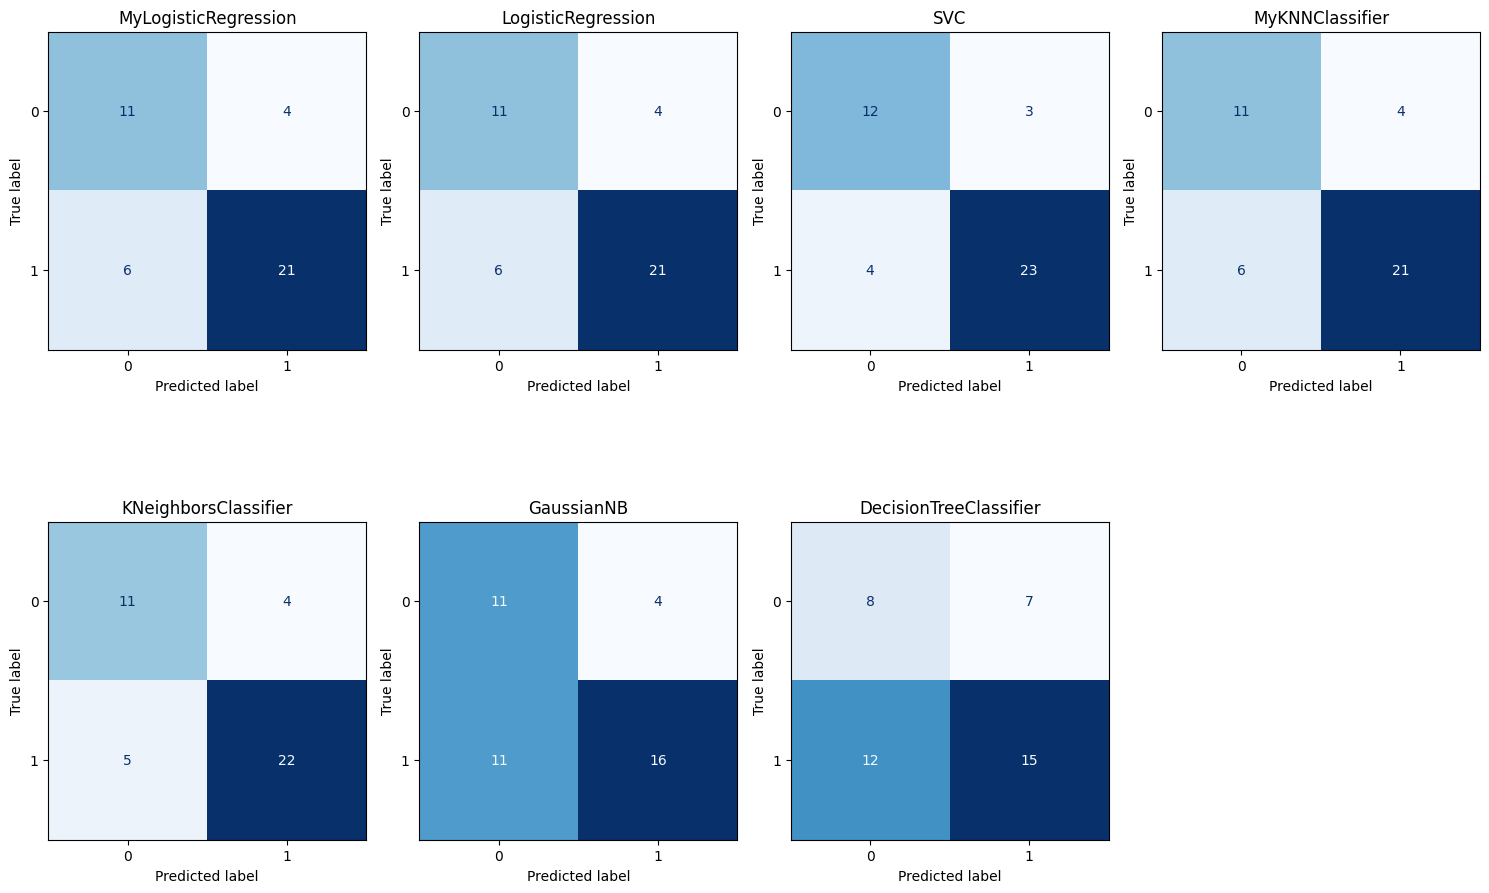

In [ ]:
train_models()

Наилучшие результаты показали классификаторы `SVC`, `KNeighborsClassifier`, `MyKNNClassifier`, `LogisticRegression` и `MyLogisticRegression`. Что примечательно, собственная реализация `MyLogisticRegression` и библиотечная реализация `LogisticRegression` снова показали идентичные результаты. Однако в этот раз библиотечная реализация `KNeighborsClassifier` показала результат немного лучше `MyKNNClassifier`, что может быть объяснено тем, что в этот раз подбор гиперпараметров предпочёл манхэттенское расстояние Евклидовому, но собственная реализация в отличие от библиотечной не поддерживает манхэттенское расстояние.